In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import csv
import math
import statistics
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.core.brain_observatory_nwb_data_set import BrainObservatoryNwbDataSet
from allensdk.brain_observatory.static_gratings import StaticGratings
import time


### Retrieve saved data from two_photon.ipynb

In [2]:
# retrieve directories
save_dirs = []
with open('../data/save_dirs.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        save_dirs.append(row[1])
save_dirs = np.array(save_dirs)[1:]

In [3]:
# split each save_dir to obtain count id and exp id
cont_ids = []
exp_ids = []
for i in range(len(save_dirs)):
    cont_ids.append(save_dirs[i].split('cont_')[1].split('_exp')[0])
    exp_ids.append(save_dirs[i].split('exp_')[1].split('_VISp')[0])
cont_ids = np.array(cont_ids)
exp_ids = np.array(exp_ids)

In [4]:
cont_ids

array(['661437138', '603576130', '603425700', '670396939', '614418789',
       '573720506', '511510675', '529763300', '511507811', '637998953',
       '616886391', '686449283', '688678764'], dtype='<U9')

In [5]:
exp_ids

array(['662351346', '603889825', '603516552', '672674054', '614535829',
       '574415929', '509962140', '529763302', '500860585', '638754323',
       '636930038', '691208363', '690045763'], dtype='<U9')

In [6]:
# retrieve meta data for each container (contains layer info)
subset_exp_cont_df = pd.read_csv('../data/subset_exp_cont_df.csv', dtype=str)
# filter out the entries where the id is not in cont_ids
subset_exp_cont_df = subset_exp_cont_df[subset_exp_cont_df['id'].isin(cont_ids)]
subset_exp_cont_df = subset_exp_cont_df.reset_index(drop=True)
subset_exp_cont_df 

,id,imaging_depth,targeted_structure,cre_line,reporter_line,donor_name,specimen_name,tags,failed,layer
0,661437138,175,VISp,Slc17a7-IRES2-Cre,Ai93(TITL-GCaMP6f),365251,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-365251,[],False,23
1,603576130,550,VISp,Ntsr1-Cre_GN220,Ai148(TIT2L-GC6f-ICL-tTA2),323982,Ntsr1-Cre_GN220;Ai148-323982,[],False,6
2,603425700,550,VISp,Ntsr1-Cre_GN220,Ai148(TIT2L-GC6f-ICL-tTA2),323984,Ntsr1-Cre_GN220;Ai148-323984,[],False,6
3,670396939,195,VISp,Pvalb-IRES-Cre,Ai162(TIT2L-GC6s-ICL-tTA2),369497,Pvalb-IRES-Cre;Ai162-369497,[],False,23
4,614418789,375,VISp,Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),332396,Sst-IRES-Cre;Ai148(CAM)-332396,[],False,5
5,573720506,275,VISp,Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),297620,Sst-IRES-Cre;Ai148(CAM)-297620,[],False,4
6,511510675,275,VISp,Rorb-IRES2-Cre,Ai93(TITL-GCaMP6f),228786,Rorb-IRES2-Cre;Camk2a-tTA;Ai93-228786,[],False,4
7,529763300,350,VISp,Nr5a1-Cre,Ai93(TITL-GCaMP6f),250605,Nr5a1-Cre;Camk2a-tTA;Ai93-250605,[],False,4
8,511507811,350,VISp,Scnn1a-Tg3-Cre,Ai93(TITL-GCaMP6f),221470,Scnn1a-Tg3-Cre;Camk2a-tTA;Ai93-221470,[],False,4
9,637998953,400,VISp,Fezf2-CreER,Ai148(TIT2L-GC6f-ICL-tTA2),339839,Fezf2-CreER;Ai148-339839,[],False,5


In [7]:
# retrieve exp data
all_experiment_data = []
all_file_names = []
for exp_id in exp_ids:
    file_name = 'ophys_experiment_data/' + exp_id + '.nwb'
    experiment_data = BrainObservatoryNwbDataSet(file_name)
    all_file_names.append(file_name)
    all_experiment_data.append(experiment_data)
all_experiment_data = np.array(all_experiment_data)
all_experiment_data.shape # 13 experiments left

(13,)

### For each exp data, run the two_photon pipeline...

In [14]:
boc = BrainObservatoryCache(manifest_file='../data/manifest.json')
# helpers
def get_ns(start, end, ns_img_list, experiment_data):
    i = start
    while i < end:
        ns_img_list.append(experiment_data.get_stimulus(i)[1])
        next_i = experiment_data.get_stimulus(i)[0][2]['end']+1
        if (next_i == i):
            break
        i = next_i


def get_stim(start, end,cell_dff, dff_stim_cell, experiment_data):
    i = start
    while i < end:
        j = experiment_data.get_stimulus(i)[0][2]['end']
        if (i >= j):
            break
        max_dff_stim = max(cell_dff[i:j])
        dff_stim_cell.append(max_dff_stim)
        ts_in_next = experiment_data.get_stimulus(i)[0][2]['end']+1
        # start_next=experiment_data.get_stimulus(ts_in_next)[0][2]['start']
        i = ts_in_next


def get_stim_avg(start, end, cell_dff,dff_stim_cell, experiment_data):
    i = start
    while i < end:
        j = experiment_data.get_stimulus(i)[0][2]['end']
        if (i >= j):
            break
        avg_dff_stim = sum(cell_dff[i:j])/len(cell_dff[i:j])
        dff_stim_cell.append(avg_dff_stim)
        i = experiment_data.get_stimulus(i)[0][2]['end']+1


def get_frames(start, end, ns_frame_list, experiment_data):
    i = start
    while i < end:
        ns_frame_list.append(experiment_data.get_stimulus(i)[0][2]['frame'])
        next_i = experiment_data.get_stimulus(i)[0][2]['end']+1
        if (next_i == i):
            break
        i = next_i


def get_sg(start, end, ori_list, freq_list, phase_list, experiment_data):
    i = start
    while i < end:
        ori_list.append(experiment_data.get_stimulus(i)[0][2]['orientation'])
        freq_list.append(experiment_data.get_stimulus(i)
                         [0][2]['spatial_frequency'])
        phase_list.append(experiment_data.get_stimulus(i)[0][2]['phase'])
        next_i = experiment_data.get_stimulus(i)[0][2]['end']+1
        if (next_i == i):
            break
        i = next_i
    # print(ori_list)


def get_max(start, end, cell_dff, dff_sg_cell, experiment_data):
    i = start
    while i < end:
        j = experiment_data.get_stimulus(i)[0][2]['end']
        if (i >= j):
            break
        max_dff_stim = max(cell_dff[i:j])
        dff_sg_cell.append(max_dff_stim)
        i = experiment_data.get_stimulus(i)[0][2]['end']+1

def peak_sig(list_peak_sig, avg_max_dff):
    for j in range(len(avg_max_dff)):
        max_dff = max(avg_max_dff[j])
        list_mean_wo_max = []
        for i in range(len(avg_max_dff[j])):
            if avg_max_dff[j][i] != max_dff:
                list_mean_wo_max.append(avg_max_dff[j][i])
        mean_wo_max = statistics.mean(list_mean_wo_max)
        peak_sig = max_dff/mean_wo_max
        list_peak_sig.append(peak_sig)

Running: container 661437138 experiement 662351346
stimulus_epoch_df acquired.
ns_start and ns_end acquired.
ns_img_list acquired.
dff_stim_all and dff_stim_avg acquired.
sg Data acquired.
pref_ori_df acquired.
[nan, 60.0, 60.0, 30.0, nan, 60.0, 150.0, 30.0, 30.0, 150.0, 60.0, nan, 150.0, 120.0, 30.0, 30.0, 60.0, 60.0, 120.0, 120.0, 60.0, 0.0, 0.0, nan, 120.0, 60.0, 120.0, 0.0, 150.0, 60.0, 60.0, 150.0, 0.0, 60.0, nan, 60.0, 30.0, 120.0, 120.0, 120.0, 150.0, 150.0, 120.0, 30.0, 90.0, 0.0, 150.0, 30.0, 0.0, 90.0, 0.0, 0.0, 60.0, 0.0, 60.0, 30.0, 30.0, 90.0, 60.0, 30.0, 90.0, 90.0, 90.0, 0.0, 30.0, 150.0, 30.0, 60.0, 150.0, 0.0, 90.0, 30.0, 60.0, 30.0, nan, 120.0, 30.0, 90.0, 120.0, 150.0, 150.0, 30.0, 30.0, 0.0, 30.0, 90.0, 0.0, 0.0, 60.0, 60.0, 150.0, 30.0, 120.0, 60.0, 0.0, 60.0, 0.0, 0.0, 150.0, 120.0, nan, 120.0, 150.0, 60.0, 30.0, 60.0, 0.0, 120.0, 120.0, 30.0, 30.0, 30.0, 150.0, 30.0, 150.0, 90.0, 60.0, 150.0, 30.0, 120.0, 150.0, 90.0, 60.0, 60.0, 60.0, 30.0, 90.0, 30.0, 0.0, 120.

ValueError: All arrays must be of the same length

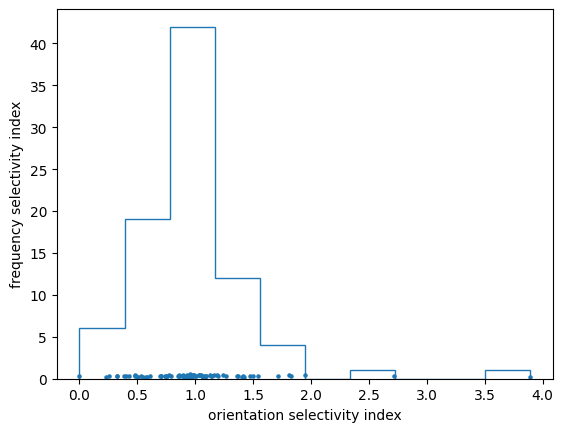

In [18]:
for i in range(len(save_dirs)):    
    cont_id = cont_ids[i]
    exp_id = exp_ids[i]
    save_dir = save_dirs[i]
    experiment_data = all_experiment_data[i]
    file_name = all_file_names[i]

    # handling the remaining experiments
    # if save_dir contains 6 csv files, skip


    # # rerun the successful ones to make sure they're all good
    # if len(os.listdir(save_dir)) != 6:
    #     continue

    print('Running:', 'container', cont_id, 'experiement', exp_id)

    # stimuli presented during each epoch: start and end frame #s for each stimulus epoch
    stimulus_epoch_df = experiment_data.get_stimulus_epoch_table()
    # print(stimulus_epoch_df)

    print('stimulus_epoch_df acquired.')

    # ts = timestamp (frame), dff=∆F/F at each frame
    ts, dff = experiment_data.get_dff_traces()

    # start and end frames for each stimulus epoch
    ns_start1 = stimulus_epoch_df.loc[1]['start']
    ns_end1 = stimulus_epoch_df.loc[1]['end']
    ns_start2 = stimulus_epoch_df.loc[3]['start']
    ns_end2 = stimulus_epoch_df.loc[3]['end']
    ns_start3 = stimulus_epoch_df.loc[6]['start']
    ns_end3 = stimulus_epoch_df.loc[6]['end']

    print('ns_start and ns_end acquired.')


    # making list of images as np arrays (not super needed but still nice)
    ns_img_list = []
    get_ns(ns_start1, ns_end1, ns_img_list, experiment_data)
    get_ns(ns_start2, ns_end2, ns_img_list, experiment_data)
    get_ns(ns_start3, ns_end3, ns_img_list, experiment_data)

    print('ns_img_list acquired.')

    # get diff traces for each frame
    # remember ts = list of each frame, dff = ∆F/F at each frame
    dff_stim_all = []  # dff_stim_all is a list of MAX dff over the interval of ONE natural scene presentation for EACH CELL
    for k in range(len(dff)):
        cell_dff=dff[k]
        dff_stim_cell=[]
        get_stim(ns_start1, ns_end1,cell_dff, dff_stim_cell, experiment_data)
        get_stim(ns_start2, ns_end2,cell_dff, dff_stim_cell, experiment_data)
        get_stim(ns_start3, ns_end3, cell_dff,dff_stim_cell, experiment_data)
        dff_stim_all.append(dff_stim_cell)
    
    # same idea, but doing mean dff over an interval
    dff_stim_avg=[] 
    for k in range(len(dff)):
        cell_dff=dff[k]
        dff_stim_cell=[]
        get_stim_avg(ns_start1, ns_end1,
                     cell_dff,dff_stim_cell, experiment_data)
        get_stim_avg(ns_start2, ns_end2, cell_dff,dff_stim_cell, experiment_data)
        get_stim_avg(ns_start3, ns_end3,
                     cell_dff,dff_stim_cell, experiment_data)
        dff_stim_avg.append(dff_stim_cell)

    print('dff_stim_all and dff_stim_avg acquired.')

    # Get the cell specimens information for this experiment
    cell_specimens = boc.get_cell_specimens(experiment_container_ids=[cont_id])
    cell_specimens_df = pd.DataFrame(cell_specimens)

    # # Get experiment for our container id and stimuli of interest
    # stim_2 = ['static_gratings']
    # sg_experiment = boc.get_ophys_experiments(experiment_container_ids=[cont_id], stimuli=stim_2)

    # # Download the experiment data using the experiment id
    # if sg_experiment == []:
    #     print('No static grating experiment for this container.')
    #     continue
    # experiment_id_2 = sg_experiment[0]['id']
    # data_sg = boc.get_ophys_experiment_data(experiment_id_2)
    # print('Data acquired.')
    data_sg = experiment_data

    print('sg Data acquired.')

    # Create my StaticGratings Object
    sg = StaticGratings(data_sg)
    # Return dataframe of peak conditions
    sg_df = sg.peak
    cell_specimen_id = sg_df['cell_specimen_id']
    num_cells = len(cell_specimen_id)
    # multiplying by 30 and adding to list of preferred orientations
    pref_ori = []
    for i in range(num_cells):
        pref_ori.append(sg_df['ori_sg'][i]*30)
    pref_ori_dict = {
        'cell_specimen_id': cell_specimen_id,
        'pref_ori': pref_ori
    }
    pref_ori_df = pd.DataFrame(pref_ori_dict)

    print('pref_ori_df acquired.')

    # make sure cells with preferred orientations also in natural scenes experiment and vice versa
    cell_ids = experiment_data.get_cell_specimen_ids()
    cell_spec_id_ori = []
    pref_ori_cell = []
    for i in range(len(pref_ori_df['cell_specimen_id'])):
        if pref_ori_df['cell_specimen_id'][i] in cell_ids:
            cell_spec_id_ori.append(pref_ori_df['cell_specimen_id'][i])
            pref_ori_cell.append(pref_ori_df['pref_ori'][i])

    # Extract osi_sg (orientation selectivity index) and sf_index_sg (????frequency selectivity index)
    osi_sg = sg_df['osi_sg']
    # there isn't any documentation stating that this is the selectivity index, but just running with it
    fsi_sg = sg_df['sf_index_sg']
    si_dict = {
        'cell_specimen_id': cell_specimen_id,
        'osi_sg': osi_sg,
        'fsi_sg': fsi_sg
    }
    si_df = pd.DataFrame(si_dict)
    # visualize
    plt.scatter(osi_sg, fsi_sg, s=5)
    plt.xlabel('orientation selectivity index')
    plt.ylabel('frequency selectivity index')
    counts, bins = np.histogram(osi_sg)
    plt.stairs(counts, bins)

    # SUBSET CELLS IN CALCIUM DATA FOR NS TO COVER CELLS SHOWN SG
    cell_id_subset = []
    dff_subset = []
    for i in range(len(cell_ids)):  
        if cell_ids[i] in cell_spec_id_ori:
            cell_id_subset.append(cell_ids[i])
            dff_subset.append(dff_stim_all[i])
    dff_subset_tuple = list(zip(cell_id_subset, dff_subset))
    dff_subset_dict = dict(dff_subset_tuple)
    dff_subset_df = pd.DataFrame(dff_subset_dict)
    dff_subset_df_tp = dff_subset_df.transpose()
    dff_subset_df_index = dff_subset_df_tp.reset_index()
    dff_final_subset_df = dff_subset_df_index.rename(columns={'index':'cell_specimen_id'})
    dff_final_subset_df.sort_values(by='cell_specimen_id')

    # same provess with mean dff
    cell_id_subset = []
    dff_mean_subset = []
    for i in range(len(cell_ids)): 
        if cell_ids[i] in cell_spec_id_ori:
            cell_id_subset.append(cell_ids[i])
            dff_mean_subset.append(dff_stim_avg[i])
    mean_dff_subset_tuple = list(zip(cell_id_subset, dff_mean_subset))
    mean_dff_subset_dict = dict(mean_dff_subset_tuple)
    mean_dff_subset_df = pd.DataFrame(mean_dff_subset_dict)
    mean_dff_final_subset_df = mean_dff_subset_df.transpose().reset_index().rename(columns={'index':'cell_specimen_id'})

    # List of frame numbers for each natural scene presentation (better than a list of actual images themselves)
    ns_frame_list = []
    get_frames(ns_start1, ns_end1, ns_frame_list, experiment_data)
    get_frames(ns_start2, ns_end2, ns_frame_list, experiment_data)
    get_frames(ns_start3, ns_end3, ns_frame_list, experiment_data)
    ns_frame_dict = {
        'frame': ns_frame_list
    }
    ns_frame_df = pd.DataFrame(ns_frame_dict)

    subset_pref_ori_dict={
    'cell_specimen_id': cell_spec_id_ori,
    'pref_ori': pref_ori_cell
    }
    subset_pref_ori_df=pd.DataFrame(subset_pref_ori_dict)
    subset_pref_ori_df

    # export as csvs, finally
    # preferred orientation for each cell (in order by cell specimen id)
    ordered_pref_ori_subset = subset_pref_ori_df.sort_values(
        by='cell_specimen_id').reset_index().drop(['index'], axis=1)
    ordered_pref_ori_subset.to_csv(
        save_dir + 'pref_ori_ordered_subset.csv', sep=',', index=False)
    # max dff for each NS presentation (in order by cell specimen id)
    ordered_dff_final_subset = dff_final_subset_df.sort_values(
        by='cell_specimen_id').reset_index().drop(['index'], axis=1)
    ordered_dff_final_subset.to_csv(
        save_dir + 'max_dff_subset_ordered.csv', sep=',', index=False)
    # mean dff for each NS presentation (in order by cell specimen id)
    ordered_mean_dff_subset = mean_dff_final_subset_df.sort_values(
        by='cell_specimen_id').reset_index().drop(['index'], axis=1)
    ordered_mean_dff_subset.to_csv(
        save_dir + 'mean_dff_subset_ordered.csv', sep=',', index=False)
    # frame of each natural scene presented throughout the experiment
    ns_stimulus_frame_presentation = ns_frame_df.to_csv(save_dir + 'ns_stim_frame_presentation.csv', sep=',', index=False)

    # OBTAIN LIST OF STATIC GRATING STIMULI IN ORDER OF PRESENTATION, GET DFF TRACES FOR EACH FRAME
    # start and end frames for each stimulus epoch
    sg_start1 = stimulus_epoch_df.loc[0]['start']
    sg_end1 = stimulus_epoch_df.loc[0]['end']
    sg_start2 = stimulus_epoch_df.loc[4]['start']
    sg_end2 = stimulus_epoch_df.loc[4]['end']
    sg_start3 = stimulus_epoch_df.loc[7]['start']
    sg_end3 = stimulus_epoch_df.loc[7]['end']

    # making dict (note, there are some random NaN in there... will deal with them)
    ori_list = []
    freq_list = []
    phase_list = []
    get_sg(sg_start1, sg_end1, ori_list, freq_list, phase_list, experiment_data)
    get_sg(sg_start2, sg_end2, ori_list, freq_list, phase_list, experiment_data)
    get_sg(sg_start3, sg_end3, ori_list, freq_list, phase_list, experiment_data)
    sg_exp_dict = {
        'orientation': ori_list,
        'frequency': freq_list,
        'phase': phase_list
    }

    # remember ts = list of each frame, dff = ∆F/F at each frame
    dff_max_sg = []  # a list of MAX dff over the interval of ONE static grating presentation for EACH CELL
    for k in range(len(dff)):
        cell_dff = dff[k]
        dff_sg_cell = []
        get_max(sg_start1, sg_end1, cell_dff,dff_sg_cell, experiment_data)
        get_max(sg_start2, sg_end2, cell_dff,dff_sg_cell, experiment_data)
        get_max(sg_start3, sg_end3, cell_dff,dff_sg_cell, experiment_data)
        dff_max_sg.append(dff_sg_cell)

    # making a data frame
    dff_sg_tuple=list(zip(cell_ids, dff_max_sg))
    dff_sg_dict=dict(dff_sg_tuple)
    dff_sg_df=pd.DataFrame(dff_sg_dict)
    dff_sg_df_tp=dff_sg_df.transpose()
    dff_sg_df_index=dff_sg_df_tp.reset_index()
    dff_final_sg_df=dff_sg_df_index.rename(columns={'index':'cell_specimen_id'})
    dff_final_sg_df=dff_final_sg_df.sort_values(by='cell_specimen_id').reset_index().drop(columns='index')
    # transpose df to prepare to associate with orientation and frequency data
    dff_final_sg_df_t=dff_final_sg_df.T
    print(len(dff_final_sg_df_t))
    
    # produce a list of lists for the average MAX dff of each cell for each ORIENTATION (averaging across each replicate)
    degrees=[0, 30, 60, 90, 120, 150]
    avg_max_dff_ori_all=[] # a list of lists: 122 lists (one for each cell), avg max dff for each ori (len 6)
    for j in range(len(dff_final_sg_df) - 1): # for each cell
        img_max_dff_i=[[]for _ in range(len(degrees))] # empty list of 6 lists for each orientation
        for i in range(len(dff_final_sg_df_t) - 1): # adding max dff scores, sorted into each list by frame number
            ori=ori_list[i]
            if math.isnan(ori):
                continue
            max_dff=dff_final_sg_df_t[j][i]
            img_max_dff_i[degrees.index(ori)].append(max_dff)
        avg_max_dff_i=[]
        for k in range(len(img_max_dff_i)):
            avg_max_dff=statistics.mean(img_max_dff_i[k])
            avg_max_dff_i.append(avg_max_dff)
        avg_max_dff_ori_all.append(avg_max_dff_i)

    freq_unique=[]
    for i in range(len(freq_list)):
        if freq_list[i] not in freq_unique:
            freq_unique.append(freq_list[i])
    freq_unique_value=[]
    for i in range(len(freq_unique)):
        if not math.isnan(freq_unique[i]):
            freq_unique_value.append(freq_unique[i])
    sorted_freq=sorted(freq_unique_value)

    # produce a list of lists for the average MAX dff of each cell for each FREQUENCY (averaging across each replicate)
    avg_max_dff_freq_all=[] # a list of lists: 122 lists (one for each cell), avg max dff for each freq (len 5)
    for j in range(len(dff_final_sg_df)): # for each cell
        img_max_dff_i=[[]for _ in range(len(sorted_freq))] # empty list of 6 lists for each orientation
        for i in range(len(dff_final_sg_df_t) - 1): # adding max dff scores, sorted into each list by frame number
            freq=freq_list[i]
            if math.isnan(freq):
                continue
            max_dff=dff_final_sg_df_t[j][i]
            img_max_dff_i[sorted_freq.index(freq)].append(max_dff)
        avg_max_dff_i=[]
        for k in range(len(img_max_dff_i)):
            avg_max_dff=statistics.mean(img_max_dff_i[k])
            avg_max_dff_i.append(avg_max_dff)
        avg_max_dff_freq_all.append(avg_max_dff_i)

    ori_peak_sig=[]
    freq_peak_sig=[]
    peak_sig(ori_peak_sig, avg_max_dff_ori_all)
    peak_sig(freq_peak_sig, avg_max_dff_freq_all)

    # make a dict with cell ids
    peak_sig_dict={
        'cell_specimen_id': sorted(cell_ids),
        'ori_peak_sig': ori_peak_sig,
        'freq_peak_sig': freq_peak_sig
    }
    peak_sig_df=pd.DataFrame(peak_sig_dict)
    plt.scatter(ori_peak_sig, freq_peak_sig, marker="o", s=5)
    plt.xlabel('orientation dff max/mean (exclusive of max)')
    plt.ylabel('frequency dff max/mean (exclusive of max)')
    sorted_sdk_osi_df=si_df.sort_values(by='cell_specimen_id')
    sorted_sdk_osi_df.sort_values(by='osi_sg')
    plt.scatter(ori_peak_sig, sorted_sdk_osi_df['osi_sg'].tolist(), s=5)
    plt.xlabel('manual osi')
    plt.ylabel('sdk osi')

    counts, bins = np.histogram(ori_peak_sig, bins=20)
    a = np.log(np.array(ori_peak_sig)-1)
    two_std_log=len(a[(a-np.mean(a)) > 2*np.std(a)])
    one_std_log=len(a[(a-np.mean(a)) > 1*np.std(a)])
    b = np.array(ori_peak_sig)
    two_std_linear=len(b[(b-np.mean(b)) > 2*np.std(b)])
    one_std_linear=len(b[(b-np.mean(b)) > np.std(b)])
    two_std_linear_df=peak_sig_df.sort_values(by='ori_peak_sig', ascending=False).head(two_std_linear)
    one_std_linear_df=peak_sig_df.sort_values(by='ori_peak_sig', ascending=False).head(one_std_linear)
    two_std_linear_df.to_csv(save_dir + 'two_std_linear.csv', index=False)
    one_std_linear_df.to_csv(save_dir + 'one_std_linear.csv', index=False)
    plt.hist(
        np.log(np.array(ori_peak_sig)-1)
    )

In [17]:
len(ori_list)

6000